# Cassini Cosmic Dust Analyzer - Project 1: Calibrating CDA

## Part 2: Calibration functions

In this session we will take a look at already existing calibration functions. R. Srama (2000 & 2009), form whom I received the calibration data, was leading the calibration task in his doctorate thesis and habilitation treatise. He conducted the experiments and measurements and determined first polynomial function to determine the *velocity* and *mass* the the dust particles.

In our calibration work we will focus only on the velocity functions. At the end of this first CDA project you could apply the methods on the corresponding mass calibration (as a small "homework").

###### References

[1] R. Srama. Cassini-Huygens and Beyond – Tools for Dust Astronomy.<br>
    Habilitation, Fakultät für Luft- und Raumfahrttechnik und Geodäsie<br>
    der Universität Stuttgart, 2009.

[2] R. Srama. Vom Cosmic-Dust-Analyzer zur Modellbeschreibung<br>
    wissenschaftlicher Raumsonden. PhD thesis, Technische Universität<br>
    München, 2000

## Read in the data

In [1]:
# Import default libraries
import pathlib
import zipfile

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Matplotlib darkmode
plt.style.use('dark_background')

# Styling
plt.rcParams.update({
    "font.size": 14
})

In [2]:
# Read in the level 1 data
cal_df = pd.read_pickle("data/level1/CDA__CAT_IID_cal_data.pkl")

In [3]:
cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR,MASS
0,17.40,1.260,3,2000000.0,8.857710,2.83,43.1122,2.33,4.52835,0.00,CAT,1.664685e-17
1,12.35,0.990,0,2000000.0,8.392480,8.16,243.3150,0.66,4.80513,0.00,CAT,2.596338e-17
2,18.70,2.030,3,2000000.0,3.897020,4.00,47.3741,1.83,3.50657,0.00,CAT,2.322057e-17
3,29.10,2.058,6,2000000.0,102.422000,4.33,496.7530,0.33,23.11490,1.33,CAT,9.721189e-18
4,11.00,2.030,0,2000000.0,0.781009,1.33,42.1289,1.50,4.81273,0.00,CAT,6.710744e-17
...,...,...,...,...,...,...,...,...,...,...,...,...
4204,9.68,2.429,7,2000000.0,10.227700,2.84,166.8690,1.83,4.71384,0.00,CAT,1.036900e-16
4205,14.78,0.990,9,2000000.0,25.061000,2.83,219.0310,1.33,5.48485,0.00,CAT,1.812785e-17
4206,14.89,0.990,4,2000000.0,7.616550,3.33,42.1660,1.17,4.70756,0.00,CAT,1.786100e-17
4207,12.29,2.506,6,2000000.0,30.925100,5.34,261.7860,1.00,5.88237,0.00,CAT,6.636472e-17


## Calibration functions

In [4]:
class DefinitionRangeError(Exception):
    """
    Class DefinitionsRangeError

    An Exception / Error class that is used to control proper calibration
    function usage. If the user uses a function with parameters that are
    out of range (outside the definition / math domain), this error can
    be raised to inform the user about the proper range.

    Attributes
    ----------
    None

    Examples

    """
    def __init__(self, trise_min=0, trise_max=np.inf, amp_min=0, amp_max=np.inf):
        """
        Method __init__

        Initializing method

        Parameters
        ----------
        trise_min : int, float, str
            Lower boundary of the rise time domain.

            Physical Quantity: microseconds (same as the calibration functions)

        trise_max : int, float, str
            Upper boundary of the rise time domain

            Physical Quantity: microseconds (same as the calibration functions)

        amp_min : int, float, str
            Lower boundary of the amplitude domain

            Physical Quantity: femtoCoulomb (same as the calibration functions)

        amp_max : int, float, str
            Upper boundary of the amplitude domain

            Physical Quantity: femtoCoulomb (same as the calibration functions)

        """


        # Set default message
        default_msg = 'Out of Range. Please set the parameters within the following range: \n\n'

        # Set message and the definition range values.
        super().__init__(default_msg \
                         + 'trise (microseconds):      (' + str(trise_min) + ', ' \
                                                          + str(trise_max) + ') \n' \
                         + 'amp (femtoCoulomb):        (' + str(amp_min)   + ', ' \
                                                          + str(amp_max)   + ') \n' \
                         + '                      log10(' + str(np.log10(amp_min)) + ', ' \
                                                          + str(np.log10(amp_max)) + ')')

In [5]:
def srama_velocity_2000(chnl, trise):
    """
    Function srama_velocity_2000

    This function computes the mean velocity and corresponding error for a
    given channel rise time. The rise time shall be given in micro seconds and
    the returned dictionary, that contains the computed values are given in
    km/s. The functions are determined by [2].

    Parameters
    ----------
    chnl : str
        Requested channel calibration function. Available options:
            'cat_qc'
            'cat_qi'
            'iid_qt'
            'iid_qi'

    trise : int, float
        Rise time value.
        Physical Quantity: microseconds

    Returns
    -------
    out : tuple
        Tuple with the mean and error velocity.

        Pysical Quantity: 'mean' : km/s
                          'err'  : km/s

    Notes:
    ------
    All three functions are defined within a certain rise time and amplitude
    domain. However, these values were not provided by [1]. Srama 2017 (priv.
    comm.) suggests to have signals with an amplitude of at least 10 fC (for
    each channel). The rise times and resulting velocities should  be handled
    with care. Extremely low velocities (< 2 - 5 km/s) and high paces
    (> 60 km/s) are mostly likely outside the definition range. Since no exact
    values are provided, no DefinitionRangeError raises.

    References
    ----------
    [2] R. Srama. Vom Cosmic-Dust-Analyzer zur Modellbeschreibung
        wissenschaftlicher Raumsonden. PhD thesis, Technische Universität
        München, 2000

    Examples
    --------
    >>> srama_velocity_2000(chnl='cat_qc', trise=10)
    (3.109411534977029, 1.5547057674885145)

    >>> srama_velocity_2000('cat_qc', trise=0.0)
    ZeroDivisionError: 0.0 cannot be raised to a negative power

    Negative rise times lead to complex number, that has no technical or
    physical meaning. 

    """
    
    # Lower the 'chnl' characters
    chnl = chnl.lower()
    
    # The calibration functions from Srama's PhD thesis are given in tens of
    # nanoseconds (10 ns). The variable, that describes the functions in his
    # thesis is named 'x' and is adapted in this function.
    x_10ns = trise * 100.0

    # Definition of each calibration function, namely of CAT QC, CAT QI, IID QT
    # and IID QI. Each function is defined as a lambda operator and is only
    # used within this function
    #
    # CAT QC: 10 x nanoseconds -> km/s
    mean_vel_cat_qc = lambda x_10ns: 5.35 + 1674270.0 * (x_10ns ** (-2.71)) \
                                     - 0.002253 * x_10ns

    # CAT QI: 10 x nanoseconds -> km/s
    mean_vel_cat_qi = lambda x_10ns: 3.535 + 18024000.0 * (x_10ns ** (-2.22)) \
                                     - 0.00127 * x_10ns

    # IID QT: 10 x nanoseconds -> km/s
    mean_vel_iid_qt = lambda x_10ns: 9.22 + 1.87 * (10.0 ** (5.0)) * (x_10ns ** (-1.26)) \
                                     - 1.45 * (10.0 ** (-3.0)) * x_10ns

    # IID QI: 10 x nanoseconds -> km/s
    mean_vel_iid_qi = lambda x_10ns: 11.3 + 3.58 * (10.0 ** (5.0)) * (x_10ns ** (-1.35)) \
                                     - 2.21 * (10.0 ** (-3.0)) * x_10ns

    # Dictionary that summarizes all parameters, functions, etc. for each
    # channel. Each sub-dictionary contains the info for each channel
    # separately.
    #
    # Structure
    # CHANNEL
    #
    #     Mean function (lambda operator)
    #     Velocity error factor
    _vel_cal = {'cat_qc': \
                    {
                        'mean_func': mean_vel_cat_qc, \
                        'err_fac':   0.50
                    }, \
                'cat_qi': \
                    {
                        'mean_func': mean_vel_cat_qi, \
                        'err_fac':   0.60
                    }, \
                'iid_qt': \
                    {
                        'mean_func': mean_vel_iid_qt, \
                        'err_fac':   0.64
                    }, \
                'iid_qi': \
                    {
                        'mean_func': mean_vel_iid_qi, \
                        'err_fac':   0.60
                    }
               }
                    
    # Compute the mean velocity in km/s, based on the rise time
    mean_vel = _vel_cal[chnl]['mean_func'](x_10ns)

    # Compute the corresponding error in km/s, based on the error factor
    err_vel = _vel_cal[chnl]['err_fac'] * mean_vel

    # Return the mean and error value
    return (mean_vel, err_vel)

In [6]:
def srama_velocity_2009(chnl, trise, amp=np.inf, chk=True):
    """
    Function srama_velocity_2009

    This function computes the mean velocity and corresponding error for a
    given channel rise time. The rise time shall be given in micro seconds and
    the returned dictionary, that contains the computed values are given in
    km/s. The functions are determined by [1].

    Parameters
    ----------
    chnl : str
        Requested channel calibration function. Available options:
            'cat_qc'
            'iid_qt'
            'iid_qi'

    trise : int, float
        Rise time value.
        Physical Quantity: microseconds

    amp : int, float, optional
        Amplitude of the corresponding signal. This value is used to verify
        the amplitude constrains for each calibration function. Per default
        the amplitude is to infinity.
        Physical Quantity: femtoCoulomb

    chk : bool, optional
        If true (default) the exception DefinitionsRangeError is raised, if
        the rise time(s) and / or amplitude(s) are outside the allowed
        domain.

    Returns
    -------
    out : tuple
        Tuple with the mean and error velocity.

        Pysical Quantity: 'mean' : km/s
                          'err'  : km/s

    Raises
    ------
    DefinitionRangeError
        If the given parameters are not within the valid math domain the
        DefinitionRangeError is raised.

    Notes:
    ------
    All three functions are defined within a certain rise time and
    amplitude domain. If the optional parameter chk is set to True, the
    function will check the values with the allowed range and raises an
    exception if a domain is violated. The following table lists the
    definition ranges, where trise_min and trise_max are the lower and upper
    range for trise, respectively, and amp_min is the lower boundary of the
    amplitude:
               | trise_min | trise_max || amp_min
       --------|-----------|-----------||---------
        cat_qc | 0.2       | 30.0      || 10
       --------|-----------|-----------||---------
        iid_qt | 2.5       | 80.0      || 65
       --------|-----------|-----------||---------
        iid_qi | 1.0       | 75.0      || 20

    References
    ----------
    [1] R. Srama. Cassini-Huygens and Beyond – Tools for Dust Astronomy.
        Habilitation, Fakultät für Luft- und Raumfahrttechnik und Geodäsie
        der Universität Stuttgart, 2009.

    Examples
    --------
    >>> srama_velocity_2009(chnl='cat_qc', trise=10, amp=15)
    (3.5111214630124583, 1.4746710144652324)

    Setting an out-of-range value leads to a DefinitionRangeError:

    >>> srama_velocity_2009(chnl='cat_qc', trise=0.1, amp=15)
    DefinitionRangeError: Out of Range. Please set the parameters within the
    following range:

    trise (microseconds): [0.2, 30.0]
    amp (femtoCoulomb):   [10.0, +inf]

    However one can deactivate this setting:

    >>> srama_velocity_2009('cat_qc', trise=0.1, amp=15, chk=False)
    (184.63482349254113, 77.54662586686727)

    ... that does not prevent, however, math domain errors:

    >>> srama_velocity_2009('cat_qc', trise=0.0, amp=15, chk=False)
    ZeroDivisionError: 0.0 cannot be raised to a negative power

    Negative rise times lead to complex number, that has no technical or
    physical meaning. These values are only returned, if the chk parameter
    is set to False

    """

    # Lower the 'chnl' characters
    chnl = chnl.lower()

    # Definition of each calibration function, namely of CAT QC, IID QT and
    # IID QI. Each function is defined as a lambda operator and is only used
    # within this function
    #
    # CAT QC: microseconds -> km/s
    mean_vel_cat_qc = lambda trise: 1.7 + 19.2 * (trise ** (-0.979)) - 0.0204 * trise

    # IID QT: microseconds -> km/s
    mean_vel_iid_qt = lambda trise: -240 + 361 * (trise ** (-0.117)) + 0.338 * trise

    # IID QI: microseconds -> km/s
    mean_vel_iid_qi = lambda trise: -55.3 + 253 * (trise ** (-0.423)) + 0.222 * trise

    # Dictionary that summarizes all parameters, functions, etc. for each
    # channel. Each sub-dictionary contains the info for each channel
    # separately.
    #
    # Structure
    # CHANNEL
    #
    #     Mean function (lambda operator)
    #     Velocity error factor
    #     Minimum rise time in microseconds
    #     Maximum rise time in microseconds
    #     Minimum amplitude in femtoCoulomb
    _vel_cal = {'cat_qc': \
                    {
                        'mean_func': mean_vel_cat_qc, \
                        'err_fac':   0.42, \
                        'trise_min': 0.2, \
                        'trise_max': 30.0, \
                        'amp_min':   10.0
                    }, \
                'iid_qt': \
                    {
                        'mean_func': mean_vel_iid_qt, \
                        'err_fac':   0.67, \
                        'trise_min': 2.5, \
                        'trise_max': 80.0, \
                        'amp_min':   65.0
                    }, \
                'iid_qi': \
                    {
                        'mean_func': mean_vel_iid_qi, \
                        'err_fac':   0.62, \
                        'trise_min': 1.0, \
                        'trise_max': 75.0, \
                        'amp_min':   20.0
                    }
               }

    # If the 'chk' parameter is set to True, the if clause will check if the
    # rise time and amplitude are within the allowed range.
    if chk:
        if (
                not _vel_cal[chnl]['trise_min'] < trise < _vel_cal[chnl]['trise_max'] or
                not _vel_cal[chnl]['amp_min'] < amp
            ):

            # If the values are outside the definition range, raise the
            # DefinitionRangeError with the allowed rise time and amplitude
            # values.
            raise DefinitionRangeError(trise_min=_vel_cal[chnl]['trise_min'], \
                                       trise_max=_vel_cal[chnl]['trise_max'], \
                                       amp_min=_vel_cal[chnl]['amp_min'])
            

    # Compute the mean velocity in km/s, based on the rise time
    mean_vel = _vel_cal[chnl]['mean_func'](trise)

    # Compute the corresponding error in km/s, based on the error factor
    err_vel = _vel_cal[chnl]['err_fac'] * mean_vel

    # Return the mean and error value
    return (mean_vel, err_vel)

In [7]:
# How does the error look like?
srama_velocity_2009("iid_qi", 10000, 10000)

DefinitionRangeError: Out of Range. Please set the parameters within the following range: 

trise (microseconds):      (1.0, 75.0) 
amp (femtoCoulomb):        (20.0, inf) 
                      log10(1.3010299956639813, inf)

## Function visualisation

In [8]:
# In our example we'll only consider IID QI data
iid_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "IID")
                           & (cal_df["QI_CHARGE"] > 0.0)
                           & (cal_df["QI_TR"] > 0.0)].copy()

Text(0, 0.5, 'Velocity in km/s')

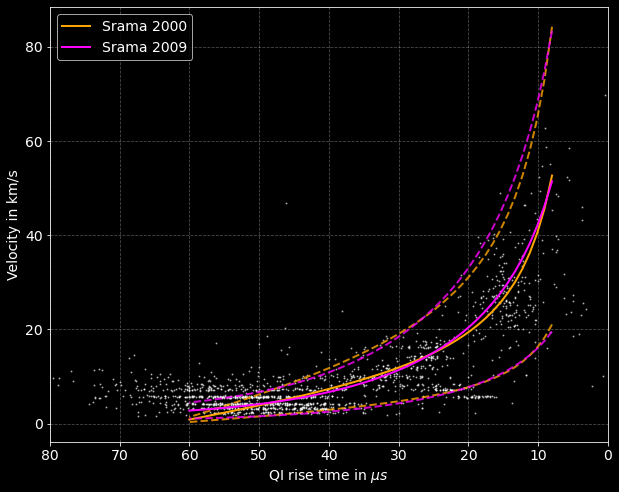

In [9]:
# Compute the velocity values and corresponding errors for both functions
qi_tr_range = np.linspace(8, 60)

vel_srama2000 = [srama_velocity_2000(chnl="IID_QI", trise=k)[0] for k in qi_tr_range]
vel_srama2009 = [srama_velocity_2009(chnl="IID_QI", trise=k, chk=False)[0] for k in qi_tr_range]

vel_srama2000 = np.array(vel_srama2000)
vel_srama2009 = np.array(vel_srama2009)

vel_err_srama2000 = [srama_velocity_2000(chnl="IID_QI", trise=k)[1] for k in qi_tr_range]
vel_err_srama2009 = [srama_velocity_2009(chnl="IID_QI", trise=k, chk=False)[1] for k in qi_tr_range]

vel_err_srama2000 = np.array(vel_err_srama2000)
vel_err_srama2009 = np.array(vel_err_srama2009)

# Plot the functions and also the calibration data points
plt.figure(figsize=(10, 8))
plt.scatter(iid_qi_cal_df["QI_TR"], iid_qi_cal_df["PSU_VEL"],
            s=1, alpha=0.5, color="w")

# Plot the Srama 2000 function
plt.plot(qi_tr_range, vel_srama2000,
         color="orange", lw=2, label="Srama 2000")
plt.plot(qi_tr_range, vel_srama2000 + vel_err_srama2000,
         color="orange", lw=2, linestyle="dashed", alpha=0.8)
plt.plot(qi_tr_range, vel_srama2000 - vel_err_srama2000,
         color="orange", lw=2, linestyle="dashed", alpha=0.8)

# Plot the Srama 2009 function
plt.plot(qi_tr_range, vel_srama2009,
         color="magenta", lw=2, label="Srama 2009")
plt.plot(qi_tr_range, vel_srama2009 + vel_err_srama2009,
         color="magenta", lw=2, linestyle="dashed", alpha=0.8)
plt.plot(qi_tr_range, vel_srama2009 - vel_err_srama2009,
         color="magenta", lw=2, linestyle="dashed", alpha=0.8)

plt.legend(fancybox=True, loc="upper left")

plt.grid(linestyle="dashed", alpha=.3)

plt.xlim(80, 0)
plt.xlabel("QI rise time in $\mu s$")
plt.ylabel("Velocity in km/s")

## Deviations

In [10]:
# Apply now the calibration functions
iid_qi_cal_df.loc[:, "vel_mean_srama2000"] = \
    iid_qi_cal_df["QI_TR"].apply(lambda x: srama_velocity_2000(chnl="IID_QI",
                                                               trise=x)[0]).copy()

In [11]:
# We need to handle the 2009 function in a loop to deal with the exception
vel_mean_array = []

for idx, row in iid_qi_cal_df.iterrows():
    
    try:
        _vel_mean, _ = srama_velocity_2009(chnl="IID_QI",
                                                  trise=row["QI_TR"],
                                                  amp=row["QI_CHARGE"],
                                                  chk=True)
    except:
        _vel_mean = np.nan
        
    vel_mean_array.append(_vel_mean)

iid_qi_cal_df.loc[:, "vel_mean_srama2009"] = vel_mean_array

In [12]:
# Let's focus only on relevant columns
iid_qi_cal_df.drop(columns=["PSU_CHARGE", "MP_PEAKS", "ACC", "QI_CHARGE", "QI_TR", "QC_CHARGE",
                            "QC_TR", "QT_CHARGE", "QT_TR", "TAR", "MASS"],
                   inplace=True)

iid_qi_cal_df.reset_index(drop=True, inplace=True)

So let's compute some error values! The Root-Mean-Square Error (RSME) and Mean Absolute Error (MAE) are some commonly used error measures to determine the "performance" of a fit. Now the MAE is "simpler" than the RSME; also in regards of "robustness". The RSME is more affected by severe outliers. Are their any? Well let's find out!

We assume that $\hat{y}_{i}$ is the i-th prediction value and ${y}_{i}$ is the corresponding data point for a calibration function with the input $x$. In total we have $N$ values; leading to the following equations:

$\text{RSME}=\sqrt{\frac{\sum_{i}^{N}\left(\hat{y}_{i}-{y}_{i}\right)^2}{N}}$<br>
$\text{MAE}=\frac{\sum_{i}^{N}\left|\hat{y}_{i}-{y}_{i}\right|}{N}$

In [13]:
# Compute the difference
iid_qi_cal_df.loc[:, "vel_diff_srama2000"] = \
    iid_qi_cal_df["vel_mean_srama2000"] - iid_qi_cal_df["PSU_VEL"]
iid_qi_cal_df.loc[:, "vel_diff_srama2009"] = \
    iid_qi_cal_df["vel_mean_srama2009"] - iid_qi_cal_df["PSU_VEL"]

In [14]:
# Compute the MAE and RMSE with all (but NaN) values
vel_diff_srama2000 = \
    iid_qi_cal_df["vel_diff_srama2000"].values
vel_diff_srama2009 = \
    iid_qi_cal_df.loc[~iid_qi_cal_df["vel_diff_srama2009"].isna()]["vel_diff_srama2009"].values

rmse_srama2000 = np.sqrt(np.mean(vel_diff_srama2000**2.0))
rmse_srama2009 = np.sqrt(np.mean(vel_diff_srama2009**2.0))

mae_srama2000 = np.mean(np.abs(vel_diff_srama2000))
mae_srama2009 = np.mean(np.abs(vel_diff_srama2009))

In [15]:
print(f"MAE of Srama [2000] in km/s: {round(mae_srama2000, 2)}")
print(f"MAE of Srama [2009] in km/s: {round(mae_srama2009, 2)}")

print(f"RMSE of Srama [2000] in km/s: {round(rmse_srama2000, 2)}")
print(f"RMSE of Srama [2009] in km/s: {round(rmse_srama2009, 2)}")

MAE of Srama [2000] in km/s: 7.62
MAE of Srama [2009] in km/s: 4.07
RMSE of Srama [2000] in km/s: 81.35
RMSE of Srama [2009] in km/s: 8.17


The RSME for Srama [2000] is pretty high! Strange ...  but recall the functions from the corresponding papers: the 2009 version has a definition range, while no definition range is provided for the 2000 version. Let's clean up a little bit.

In [16]:
# First, let's check the mean values ...
iid_qi_cal_df["vel_mean_srama2000"].sort_values()

671       -6.905162
23        -5.585434
476       -5.250266
974       -5.084635
623       -4.747189
           ...     
292      142.167498
694      161.070505
1525     238.794355
682     1262.849706
766     3075.914418
Name: vel_mean_srama2000, Length: 1634, dtype: float64

In [17]:
# There are strange negative and extremely high values. Let's apply our own filtering:
vel_diff_srama2000 = \
    iid_qi_cal_df.loc[(iid_qi_cal_df["vel_mean_srama2000"]>0)
                      & (iid_qi_cal_df["vel_mean_srama2000"]<=60)]["vel_diff_srama2000"].values
vel_diff_srama2009 = \
    iid_qi_cal_df.loc[~iid_qi_cal_df["vel_diff_srama2009"].isna()]["vel_diff_srama2009"].values

rmse_srama2000 = np.sqrt(np.mean(vel_diff_srama2000**2.0))
rmse_srama2009 = np.sqrt(np.mean(vel_diff_srama2009**2.0))

mae_srama2000 = np.mean(np.abs(vel_diff_srama2000))
mae_srama2009 = np.mean(np.abs(vel_diff_srama2009))

print(f"MAE of Srama [2000] in km/s: {round(mae_srama2000, 2)}")
print(f"MAE of Srama [2009] in km/s: {round(mae_srama2009, 2)}")

print(f"RMSE of Srama [2000] in km/s: {round(rmse_srama2000, 2)}")
print(f"RMSE of Srama [2009] in km/s: {round(rmse_srama2009, 2)}")

MAE of Srama [2000] in km/s: 3.97
MAE of Srama [2009] in km/s: 4.07
RMSE of Srama [2000] in km/s: 5.84
RMSE of Srama [2009] in km/s: 8.17


Let's keep these values in mind when we create our own, Deep Learning based calibration function